# Importing Libraries

In [ ]:
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve,precision_recall_curve, auc,confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Importing Dataset

In [ ]:
# The dataframe is read from the csv file - healthcare-dataset-stroke-data.csv - taken from kaggle
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Printing the number of N/A values in eacg column
print(df.isna().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


# Preprocessing Data

## Cleansing data

### Remove ID

In [ ]:
# The 'id' column is dropped since the attribute holds no significant importance to the problem at hand
df = df.drop(['id'],axis=1)

### Remove Gender

In [ ]:
# Checking the values in the gender column
df['gender'].value_counts()

,count
gender,
Female,2994
Male,2115
Other,1


In [ ]:
# We have a 'other' gender and since there is only 1 instance we will remove it as to reduce the dimension of age
df['gender'] = df['gender'].replace('Other','Female')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Imputating Missing Value

In [ ]:
# Number of BMI - NULL values
df['bmi'].isnull().sum()

201

<Axes: ylabel='bmi'>

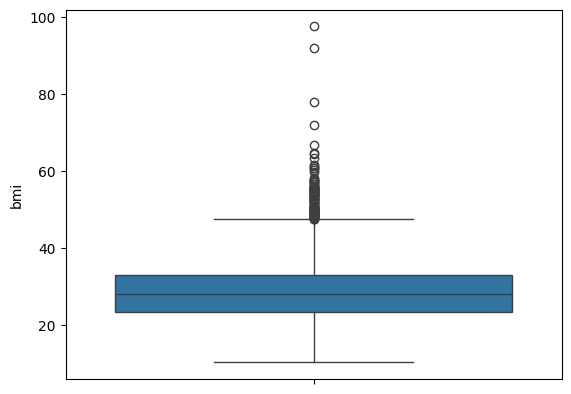

In [ ]:
sns.boxplot(data=df['bmi'])

In [ ]:
# Finding the count of outliers based on those instances which are out of iqr
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
# Finding IQR
IQR = Q3 - Q1
da=(df['bmi'] < (Q1 - 1.5 * IQR)) | (df['bmi'] > (Q3 + 1.5 * IQR))
da.value_counts()

,count
bmi,
False,5000
True,110


In [ ]:
print("Skewness BMI:", skew(df['bmi'].dropna()))

Skewness BMI: 1.0550177068872404


Distribusi BMI agak skewed ke kanan (positively skewed) Meski tidak ekstrem, ini berarti distribusi memiliki ekor yang lebih panjang di sisi nilai BMI yang lebih besar (outliner)


In [ ]:
# Imputing the missing N/A values using the median of bmi column
print("median of bmi",df['bmi'].median())
df['bmi']=df['bmi'].fillna(df['bmi'].median())

median of bmi 28.1


In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Tranformation (Encoding)

Dividing features into Numeric and Categorical

In [ ]:
col = list(df.columns)
categorical_features = []
numeric_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numeric_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Discrete Features :',*numeric_features)

df['age'] = df['age'].astype(int)
df1 = df.copy(deep = True)

Categorical Features : gender hypertension heart_disease ever_married work_type Residence_type smoking_status stroke
Discrete Features : age avg_glucose_level bmi


In [ ]:
le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for feature in text_data_features:
    df1[feature] = le.fit_transform(df1[feature])

In [ ]:
df1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,2,1,228.69,36.6,1,1
1,0,61,0,0,1,3,0,202.21,28.1,2,1
2,1,80,0,1,1,2,0,105.92,32.5,2,1
3,0,49,0,0,1,2,1,171.23,34.4,3,1
4,0,79,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80,1,0,1,2,1,83.75,28.1,2,0
5106,0,81,0,0,1,3,1,125.20,40.0,2,0
5107,0,35,0,0,1,3,0,82.99,30.6,2,0
5108,1,51,0,0,1,2,0,166.29,25.6,1,0


## Handling Imbalance Data

stroke
0    4861
1     249
Name: count, dtype: int64


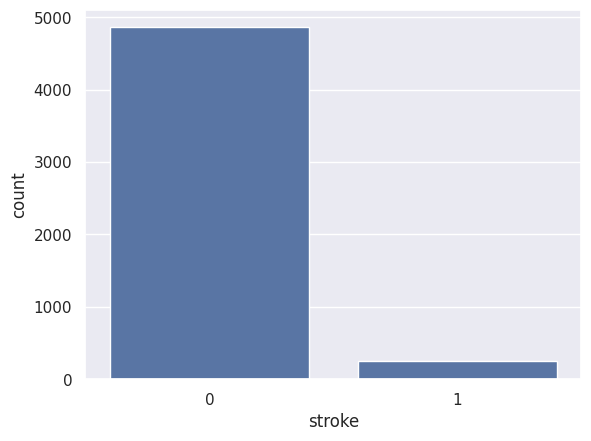

In [ ]:
print(df.stroke.value_counts())
sns.set_theme(style="darkgrid")
ax = sns.countplot(data=df, x="stroke")
plt.show()

From above dependent variable, we have really less peoples who suffered stroke. But, this also means that our dataset is imbalance. We likely have to use sampling techniques to make the data balance.

In [ ]:
# Pisahkan fitur (X) dan target (y)
x = df1.drop(columns=['stroke'])
y = df1['stroke']

In [ ]:
# Perform random oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(x, y)

In [ ]:
# Scaling fitur yang numerik
s = StandardScaler()
X_over[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(X_over[['bmi', 'avg_glucose_level', 'age']])

# Split data setelah oversampling dan scaling
x_train, x_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42, stratify=y_over)

# Checking the size of the splits
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)
print('X_test:', x_test.shape)
print('y_test:', y_test.shape)

# Menampilkan jumlah label setelah oversampling
print("After OverSampling, counts of label '1': {}".format(sum(y_over == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_over == 0)))

X_train: (7777, 10)
y_train: (7777,)
X_test: (1945, 10)
y_test: (1945,)
After OverSampling, counts of label '1': 4861
After OverSampling, counts of label '0': 4861


# Pemodelan

## Random Forest

#### Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Inisialisasi RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Definisikan ruang pencarian hyperparameter
rf_parameter = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_depth': [None] + [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Inisialisasi RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_parameter,
    n_iter=100,  # jumlah iterasi pencarian, dapat disesuaikan
    scoring=make_scorer(f1_score, average='weighted'),  # Menggunakan F1-score
    cv=5,  # 5-fold cross-validation
    verbose=2,  # menampilkan hasil selama pencarian
    random_state=42,
    n_jobs=-1  # menggunakan semua core prosesor yang tersedia
)

# Melatih model dengan RandomizedSearchCV
random_search_rf.fit(x_train, y_train)

# Mendapatkan parameter dan skor terbaik
rf_best_params = random_search_rf.best_params_
rf_best_score = random_search_rf.best_score_

print('Best parameters: ', rf_best_params)
print('Best score: ', rf_best_score)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}
Best score:  0.9947271617666251


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
model_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=40,
    bootstrap=False
)
# Fit model ke data latih dan lakukan prediksi
model_rf.fit(x_train, y_train)
rf_pred = cross_val_predict(model_rf, x_test, y_test, cv=5)

# Hitung confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)

# Tampilkan confusion matrix
print('Confusion Matrix\n\n',rf_cm)
print('True Positives(TP) = ', rf_cm[0,0])
print('True Negatives(TN) = ', rf_cm[1,1])
print('False Positives(FP) = ', rf_cm[0,1])
print('False Negatives(FN) = ', rf_cm[1,0])

accuracy_rf = accuracy_score(y_test, rf_pred)
precision_rf = precision_score(y_test, rf_pred)
recall_rf = recall_score(y_test, rf_pred)
f1_rf = f1_score(y_test, rf_pred)

print("\nData Uji:")
print("Accuracy of random forest: {:.2f}%".format(round(accuracy_rf*100, 2)))
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Confusion Matrix

 [[878  95]
 [ 27 945]]
True Positives(TP) =  878
True Negatives(TN) =  945
False Positives(FP) =  95
False Negatives(FN) =  27

Data Uji:
Accuracy of random forest: 93.73%
Accuracy: 0.9372750642673522
Precision: 0.9086538461538461
Recall: 0.9722222222222222
F1 Score: 0.9393638170974155


### Feature Importance

In [ ]:
# Mendapatkan fitur importance
feature_importance_rf = model_rf.feature_importances_

base_imp_rf = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance_rf}).sort_values('Importance', ascending=False)
base_imp_rf

,Feature,Importance
1,age,0.389845
7,avg_glucose_level,0.210440
8,bmi,0.181082
5,work_type,0.052892
9,smoking_status,0.050363
2,hypertension,0.029188
4,ever_married,0.028273
0,gender,0.020310
6,Residence_type,0.020169
3,heart_disease,0.017437


In [ ]:
from sklearn.feature_selection import SelectFromModel
# Menentukan threshold untuk feature importance
threshold = np.median(feature_importance_rf) # Misalnya, menggunakan tengah sebagai threshold

# Memilih fitur yang memiliki feature importance di atas threshold
selected_features = x_train.columns[(feature_importance_rf > threshold)]
x_train_rf = x_train[selected_features]
x_test_rf = x_test[selected_features]

# Fit model dengan fitur yang dipilih
model_rf.fit(x_train_rf, y_train)

# prediksi dengan fitur yang dipilih
rf_pred_importance = cross_val_predict(model_rf, x_test_rf, y_test, cv=5)

# Hitung confusion matrix setelah menggunakan feature importance
rf_cm_imp = confusion_matrix(y_test, rf_pred_importance)

# Tampilkan confusion matrix setelah menggunakan feature importance
print("\nConfusion Matrix Setelah Feature Importance:")
print(rf_cm_imp)

# Evaluasi model dengan feature importance
accuracy_rf_imp = accuracy_score(y_test, rf_pred_importance)
precision_rf_imp = precision_score(y_test, rf_pred_importance)
recall_rf_imp = recall_score(y_test, rf_pred_importance)
f1_rf_imp = f1_score(y_test, rf_pred_importance)

print("\nData Uji:")
print("Accuracy of Extreme Gradient Boost: {:.2f}%".format(round(accuracy_rf_imp*100, 2)))
print(f"Accuracy: {accuracy_rf_imp}")
print(f"Precision: {precision_rf_imp}")
print(f"Recall: {recall_rf_imp}")
print(f"F1 Score: {f1_rf_imp}")


Confusion Matrix Setelah Feature Importance:
[[869 104]
 [ 24 948]]

Data Uji:
Accuracy of Extreme Gradient Boost: 93.42%
Accuracy: 0.9341902313624678
Precision: 0.9011406844106464
Recall: 0.9753086419753086
F1 Score: 0.9367588932806324


## Naive Bayes

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
model_nb = GaussianNB()
# Fit model ke data latih dan lakukan prediksi
model_nb.fit(x_train, y_train)
nb_pred = cross_val_predict(model_nb, x_test, y_test, cv=5)

# Hitung confusion matrix
nb_cm = confusion_matrix(y_test, nb_pred)

# Tampilkan confusion matrix
print('Confusion Matrix\n\n',nb_cm)
print('True Positives(TP) = ', nb_cm[0,0])
print('True Negatives(TN) = ', nb_cm[1,1])
print('False Positives(FP) = ', nb_cm[0,1])
print('False Negatives(FN) = ', nb_cm[1,0])

accuracy_nb = accuracy_score(y_test, nb_pred)
precision_nb = precision_score(y_test, nb_pred)
recall_nb = recall_score(y_test, nb_pred)
f1_nb = f1_score(y_test, nb_pred)

print("\nData Uji:")
print("Accuracy of random forest: {:.2f}%".format(round(accuracy_nb*100, 2)))
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")

Confusion Matrix

 [[718 255]
 [230 742]]
True Positives(TP) =  718
True Negatives(TN) =  742
False Positives(FP) =  255
False Negatives(FN) =  230

Data Uji:
Accuracy of random forest: 75.06%
Accuracy: 0.7506426735218509
Precision: 0.7442326980942828
Recall: 0.7633744855967078
F1 Score: 0.7536820721178263


### Feature Importance

In [ ]:
# Mendapatkan fitur importance menggunakan fungsi permutation_importance
feature_importance_nb = permutation_importance(model_nb, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1) # Added necessary parameters

# Extracting the mean importance values
feature_importance_nb = feature_importance_nb.importances_mean # Extract importances_mean

base_imp_nb = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance_nb}).sort_values('Importance', ascending=False)
base_imp_nb

,Feature,Importance
1,age,0.113316
2,hypertension,0.023445
4,ever_married,0.020257
7,avg_glucose_level,0.018303
3,heart_disease,0.015424
5,work_type,0.004730
8,bmi,0.004319
6,Residence_type,0.001491
0,gender,-0.000206
9,smoking_status,-0.002776


In [ ]:
from sklearn.feature_selection import SelectFromModel
# Menentukan threshold untuk feature importance
threshold = np.median(feature_importance_nb) # Misalnya, menggunakan tengah sebagai threshold

# Memilih fitur yang memiliki feature importance di atas threshold
selected_features = x_train.columns[(feature_importance_nb > threshold)]
x_train_nb = x_train[selected_features]
x_test_nb = x_test[selected_features]

# Fit model dengan fitur yang dipilih
model_nb.fit(x_train_nb, y_train)

# prediksi dengan fitur yang dipilih
nb_pred_importance = cross_val_predict(model_nb, x_test_nb, y_test, cv=5)

# Hitung confusion matrix setelah menggunakan feature importance
nb_cm_imp = confusion_matrix(y_test, nb_pred_importance)

# Tampilkan confusion matrix setelah menggunakan feature importance
print("\nConfusion Matrix Setelah Feature Importance:")
print(nb_cm_imp)

# Evaluasi model dengan feature importance
accuracy_nb_imp = accuracy_score(y_test, nb_pred_importance)
precision_nb_imp = precision_score(y_test, nb_pred_importance)
recall_nb_imp = recall_score(y_test, nb_pred_importance)
f1_nb_imp = f1_score(y_test, nb_pred_importance)

print("\nData Uji:")
print("Accuracy of Extreme Gradient Boost: {:.2f}%".format(round(accuracy_nb_imp*100, 2)))
print(f"Accuracy: {accuracy_nb_imp}")
print(f"Precision: {precision_nb_imp}")
print(f"Recall: {recall_nb_imp}")
print(f"F1 Score: {f1_nb_imp}")


Confusion Matrix Setelah Feature Importance:
[[734 239]
 [222 750]]

Data Uji:
Accuracy of Extreme Gradient Boost: 76.30%
Accuracy: 0.7629820051413881
Precision: 0.7583417593528817
Recall: 0.7716049382716049
F1 Score: 0.7649158592554819


## Logistic Regression

### Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

# Inisialisasi Logistic Regression
lr = LogisticRegression(random_state=42)

# Definisikan ruang pencarian hyperparameter
lr_parameter = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500]
}

# Inisialisasi RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=lr_parameter,
    n_iter=50,  # jumlah iterasi pencarian
    scoring=make_scorer(f1_score, average='weighted'),  # Menggunakan F1-score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Melatih model dengan RandomizedSearchCV
random_search_lr.fit(x_train, y_train)

# Mendapatkan parameter dan skor terbaik
lr_best_params = random_search_lr.best_params_
lr_best_score = random_search_lr.best_score_

print('Best parameters: ', lr_best_params)
print('Best score: ', lr_best_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'C': 0.01}
Best score:  0.7684239253321097


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
model_lr = LogisticRegression(
    C=0.01,
    max_iter=300,
    solver='liblinear',
    penalty='l1',
)
# Fit model ke data latih dan lakukan prediksi
model_lr.fit(x_train, y_train)
lr_pred = cross_val_predict(model_lr, x_test, y_test, cv=5)

# Hitung confusion matrix
lr_cm = confusion_matrix(y_test, lr_pred)
# Tampilkan confusion matrix
print("\nConfusion Matrix Data Uji:")
print(lr_cm)

accuracy_lr = accuracy_score(y_test, lr_pred)
precision_lr = precision_score(y_test, lr_pred)
recall_lr = recall_score(y_test, lr_pred)
f1_lr = f1_score(y_test, lr_pred)

print("\nData Uji:")
print("Accuracy of random forest: {:.2f}%".format(round(accuracy_lr*100, 2)))
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")


Confusion Matrix Data Uji:
[[668 305]
 [145 827]]

Data Uji:
Accuracy of random forest: 76.86%
Accuracy: 0.7686375321336761
Precision: 0.730565371024735
Recall: 0.8508230452674898
F1 Score: 0.7861216730038023


### Feature Importance

In [ ]:
# Mendapatkan fitur importance menggunakan koefisien
feature_importance_lr = model_lr.coef_[0]  # Mengambil koefisien dari kelas pertama (jika biner)

# Membuat DataFrame untuk menampilkan feature importance
base_imp_lr = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance_lr}).sort_values('Importance', ascending=False)
base_imp_lr

,Feature,Importance
1,age,1.523896
7,avg_glucose_level,0.200862
0,gender,0.000000
2,hypertension,0.000000
3,heart_disease,0.000000
4,ever_married,0.000000
6,Residence_type,0.000000
8,bmi,0.000000
9,smoking_status,-0.020624
5,work_type,-0.024153


In [ ]:
from sklearn.feature_selection import SelectFromModel
# Menentukan threshold untuk feature importance
threshold = np.median(feature_importance_lr) # Misalnya, menggunakan tengah sebagai threshold

# Memilih fitur yang memiliki feature importance di atas threshold
selected_features = x_train.columns[(feature_importance_lr > threshold)]
x_train_lr = x_train[selected_features]
x_test_lr = x_test[selected_features]

# Fit model dengan fitur yang dipilih
model_lr.fit(x_train_lr, y_train)

# prediksi dengan fitur yang dipilih
lr_pred_importance = cross_val_predict(model_lr, x_test_lr, y_test, cv=5)

# Hitung confusion matrix setelah menggunakan feature importance
lr_cm_imp = confusion_matrix(y_test, lr_pred_importance)

# Tampilkan confusion matrix setelah menggunakan feature importance
print("\nConfusion Matrix Setelah Feature Importance:")
print(lr_cm_imp)

# Evaluasi model dengan feature importance
accuracy_lr_imp = accuracy_score(y_test, lr_pred_importance)
precision_lr_imp = precision_score(y_test, lr_pred_importance)
recall_lr_imp = recall_score(y_test, lr_pred_importance)
f1_lr_imp = f1_score(y_test, lr_pred_importance)

print("\nData Uji:")
print("Accuracy of Extreme Gradient Boost: {:.2f}%".format(round(accuracy_lr_imp*100, 2)))
print(f"Accuracy: {accuracy_lr_imp}")
print(f"Precision: {precision_lr_imp}")
print(f"Recall: {recall_lr_imp}")
print(f"F1 Score: {f1_lr_imp}")


Confusion Matrix Setelah Feature Importance:
[[668 305]
 [145 827]]

Data Uji:
Accuracy of Extreme Gradient Boost: 76.86%
Accuracy: 0.7686375321336761
Precision: 0.730565371024735
Recall: 0.8508230452674898
F1 Score: 0.7861216730038023
